# Text analysis
## Requisites
Done in python as several libraries are good enough for the text analysis, or even better than in R.
- Data scraping: `twint`
- Data management: `pandas`
  - https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
- Text processing and sentiment analysis: `nltk`
  - Look at VADER for the sentiment analysis: `nltk.sentiment.vader.SentimentIntensityAnalyzer`
- Plotting: `seaborn` (or the built-in pandas graphs)
- Topic analysis: `corextopic`
  - <a href='https://github.com/gregversteeg/corex_topic'>Github repo</a>

## Steps
1. Scrape tweets
2. Import the data into pandas
3. Sentiment analysis
4. Process the text (e.g. tokenization, lemmatization, corpus, etc.)
5. Word cloud
6. Topic analysis
7. Combine both sentiment and topic analysis

## 1. Scrape tweets
Take into consideration that it can take around 1 hour to compile all of the tweets

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


file_name = f"./twitter_data_harbor.csv"

In [109]:
%%script false --no-raise-error
# https://github.com/twintproject/twint/wiki/Configuration
import twint

values_to_search = [
    "#ABPSouthampton",
    "#DP_World",
    "#GaPorts",
    "#PortofHamburg",
    "#HutchisonPPC",
    "#LondonPortAuth",
    "#PANYNJ",
    "#portdebarcelona",
    "#PortMTL",
    "#Port_Houston",
    "#PortofAntwerp",
    "#felixstowe_port",
    "#portoflongbeach",
    "#PortofLA",
    "#PortofOakland",
    "#PortOfRotterdam",
    "#PortofSeattle",
    "#PortVancouver",
    "#Port_Zeebrugge",
    "#portodigenova",
    "#PuertoAlgeciras",
    "#PuertodeCtg",
    "#SCPorts",
    "#PortofVirginia",
    "#AutPortValencia"
]

value = ['"port" and "expansion"'] # both words should be included

value = ['port'] # only port

value = ['harbour']

c = twint.Config()
for value in values_to_search:
    # c.Limit = 1000
    file_name = f"./twitter_data_{value}.csv"
    c.Output = file_name
    c.Store_csv = True
    c.Search = value
    c.Filter_retweets = True
    c.Lang = "en"
    twint.run.Search(c)

## 2. Importing the data

In [110]:
import pandas as pd
twitter_data = pd.read_csv(file_name)
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47034 entries, 0 to 47033
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               47034 non-null  int64  
 1   conversation_id  47034 non-null  int64  
 2   created_at       47034 non-null  object 
 3   date             47034 non-null  object 
 4   time             47034 non-null  object 
 5   timezone         47034 non-null  int64  
 6   user_id          47034 non-null  int64  
 7   username         47034 non-null  object 
 8   name             47034 non-null  object 
 9   place            1212 non-null   object 
 10  tweet            47034 non-null  object 
 11  language         47034 non-null  object 
 12  mentions         47034 non-null  object 
 13  urls             47034 non-null  object 
 14  photos           47034 non-null  object 
 15  replies_count    47034 non-null  int64  
 16  retweets_count   47034 non-null  int64  
 17  likes_count 

In [111]:
import re

# Only take the columns that are interesting
reduced_twitter = twitter_data[
    # Only English tweets
    (twitter_data['language']=='en') &
    # Only original tweets, no retweets
    (twitter_data['retweet']==False)
]

# Reduce size by only taking tweets and id
columns_to_keep = pd.Series(['id', 'tweet'])
reduced_twitter = reduced_twitter[columns_to_keep]

# Clean tweets from hastags, mentions, etc.
regex_cleanup_strings = [
    # Remove links
    r"\S*https?:\S*",
    # Remove mentions
    r"(?:\@|https?\://)\S+",
    # Remove hashtags
    "#([a-zA-Z0-9_]{1,50})"
]
reduced_twitter["clean_tweet"] = reduced_twitter["tweet"]
for reg_string in regex_cleanup_strings:
    reduced_twitter["clean_tweet"] = reduced_twitter["clean_tweet"].replace(reg_string, '', regex=True)

reduced_twitter.reset_index(drop=True,inplace=True)
reduced_twitter.head()

,id,tweet,clean_tweet
0,1503343238714900483,@nyxtarina I'm glad 💚,I'm glad 💚
1,1503342989778763777,@ambehenry58 I'd rather they dont kill civilia...,I'd rather they dont kill civilians but it is...
2,1503342936288808961,David Harbour Takes on Dark Holiday Thriller V...,David Harbour Takes on Dark Holiday Thriller V...
3,1503342931234668545,I've hired my friend to hack into the system a...,I've hired my friend to hack into the system a...
4,1503342860841938950,@wildethingy Same reason he put that hurricane...,Same reason he put that hurricane on Marsh Ha...


### 2. Sentiment analysis
For sentiment analysis, VADER rates depending on the form of the word. Therefore, it should NOT be lemmatized or stemmed. For topic classification, it SHOULD be, as a bag-of-words is given.

In [112]:
# Sentiment analysis using VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sentiment_analysis = pd.DataFrame(sid.polarity_scores(clean_tweet) for clean_tweet in reduced_twitter["clean_tweet"])

processed_twitter = pd.concat([reduced_twitter,  sentiment_analysis], axis=1)
processed_twitter.sort_values(by=['pos'], ascending=False).head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,tweet,clean_tweet,neg,neu,pos,compound
33825,1500791621515943936,Amazing!,Amazing!,0.0,0.0,1.0,0.6239
4805,1503075799594725376,@Clark1995Clark @rickygervais @StephenAtHome P...,Perfection.,0.0,0.0,1.0,0.5719
36255,1500580607365165060,Good,Good,0.0,0.0,1.0,0.4404
8660,1502742355572666371,@rexorangecounty Amazing,Amazing,0.0,0.0,1.0,0.5859
12040,1502450680249798657,@PattyMurray Yes please!,Yes please!,0.0,0.0,1.0,0.6476
16295,1502121938919043073,@John_Harbour woot! woot!,woot! woot!,0.0,0.0,1.0,0.7339
34183,1500744111237783553,@UTDMoh_ Agreed,Agreed,0.0,0.0,1.0,0.2732
2004,1503125376033177604,@Jim_M58 Thanks,Thanks,0.0,0.0,1.0,0.4404
31661,1500932425110675456,@Lanette_R1 🤔 Interesting 🧐,🤔 Interesting 🧐,0.0,0.0,1.0,0.4019
31542,1500940021871874055,@AmBusyPoeming @1stLoicYouKnow @harbor_review ...,Congratulations,0.0,0.0,1.0,0.5994


### 3. Process the text (e.g. tokenization, lemmatization and stop-words)

In [113]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
import nltk

test_sentence = "This is a very random test sentence. Let's see what happens churches"
print(test_sentence)

def sentence_processing(sentence:str, printing:bool = False):
    # Tokenize
    tokens = nltk.tokenize.word_tokenize(sentence.lower())
    if printing: print(tokens)

    # Remove punctuation
    tokens = [token for token in tokens if token.isalnum()]
    if printing: print(tokens)

    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))  
    tokens = [w for w in tokens if not w in stop_words]
    if printing: print(tokens)

    # Lemmatice
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    if printing: print(tokens)

    # # Stemming
    # stemmer = nltk.stem.SnowballStemmer("english")
    # tokens = [stemmer.stem(w) for w in tokens]
    # if printing: print(tokens)

    return tokens

sentence_processing(test_sentence, printing=True)

This is a very random test sentence. Let's see what happens churches
['this', 'is', 'a', 'very', 'random', 'test', 'sentence', '.', 'let', "'s", 'see', 'what', 'happens', 'churches']
['this', 'is', 'a', 'very', 'random', 'test', 'sentence', 'let', 'see', 'what', 'happens', 'churches']
['random', 'test', 'sentence', 'let', 'see', 'happens', 'churches']
['random', 'test', 'sentence', 'let', 'see', 'happens', 'church']


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['random', 'test', 'sentence', 'let', 'see', 'happens', 'church']

In [114]:
# Actual tokenization using the custom-made function
processed_twitter["tokens"] = processed_twitter["clean_tweet"].apply(lambda sentence: sentence_processing(sentence))
processed_twitter.head(20)

,id,tweet,clean_tweet,neg,neu,pos,compound,tokens
0,1503343238714900483,@nyxtarina I'm glad 💚,I'm glad 💚,0.000,0.250,0.750,0.4588,[glad]
1,1503342989778763777,@ambehenry58 I'd rather they dont kill civilia...,I'd rather they dont kill civilians but it is...,0.217,0.692,0.091,-0.6464,"[rather, dont, kill, civilian, riddle, civilia..."
2,1503342936288808961,David Harbour Takes on Dark Holiday Thriller V...,David Harbour Takes on Dark Holiday Thriller V...,0.352,0.472,0.176,-0.7269,"[david, harbour, take, dark, holiday, thriller..."
3,1503342931234668545,I've hired my friend to hack into the system a...,I've hired my friend to hack into the system a...,0.133,0.769,0.098,-0.0299,"[hired, friend, hack, system, delete, station,..."
4,1503342860841938950,@wildethingy Same reason he put that hurricane...,Same reason he put that hurricane on Marsh Ha...,0.000,1.000,0.000,0.0000,"[reason, put, hurricane, marsh, harbor]"
5,1503342728024891394,First swim of the week was very welcome. My sa...,First swim of the week was very welcome. My sa...,0.035,0.736,0.229,0.9020,"[first, swim, week, welcome, salty, friend, co..."
6,1503342698073317385,"🛩️ Their hearts were strong, and their courage...","🛩️ Their hearts were strong, and their courage...",0.100,0.668,0.231,0.6249,"[heart, strong, courage, radioman, memoir, pea..."
7,1503342690385158145,Ballintoy Harbour; one of Game of Thrones loca...,Ballintoy Harbour; one of Game of Thrones loca...,0.000,1.000,0.000,0.0000,"[ballintoy, harbour, one, game, throne, locati..."
8,1503342681367498754,"December 8, 1941: another war starts https://...","December 8, 1941: another war starts",0.438,0.562,0.000,-0.5994,"[december, 8, 1941, another, war, start]"
9,1503342643920658438,@Fern_Britton Peace is beautiful I live by a h...,Peace is beautiful I live by a harbour 🙏,0.000,0.351,0.649,0.8126,"[peace, beautiful, live, harbour]"


### Remove short tweets

In [115]:
# Number of words column
processed_twitter["num_tokens"] = processed_twitter["tokens"].apply(lambda tokens: len(tokens))
print(f"Rows before removing short tweets: {len(processed_twitter.index)}")
# Remove short tweets
processed_twitter.drop(processed_twitter[processed_twitter["num_tokens"] < 5].index, inplace=True)
print(f"Rows after removing short tweets: {len(processed_twitter.index)}")

Rows before removing short tweets: 39420
Rows after removing short tweets: 34399


### Remove NaN

In [116]:
processed_twitter.dropna(how='any',inplace=True)
print(f"Rows after removing NaN: {len(processed_twitter.index)}")

Rows after removing NaN: 34399


### Topic categorization

First, the tokens need to be processed into a bag of words.
It is sparse (for storage) and `sklearn` does wonders for it (although it needs the tokens as a single string).

In [117]:
from sklearn.feature_extraction.text import CountVectorizer

# Obtain bag-of-words sparse matrix
corpus = [' '.join(tokens) for tokens in processed_twitter["tokens"]]
print(corpus[0])

vectorizer = CountVectorizer(analyzer='word', stop_words='english')
word_bag = vectorizer.fit_transform(corpus) # this is a sparse matrix!
word_features = vectorizer.get_feature_names_out()
ids = processed_twitter["id"].tolist()
print(word_features)
print(word_bag.shape)
len(word_features)


rather dont kill civilian riddle civilian harbour terrorist
['000' '0001784567' '000s' ... '𝟭𝟏𝘁𝗵' '𝟭𝟐𝘁𝗵' '𝟱𝟳𝟯']
(34399, 34674)


34674

Note that `anchor_strength=2` would mean that the anchor words count twice as much as a normal one.

In [118]:
# Anchor words
# Topic modelling
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import numpy as np

num_topics= 30
anchors =[
    ['economy', 'profit', 'international', 'infrastructure', 'business', 'company', 'relations', 'revenue','import', 'export'], # economy
    ['green', 'climate', 'emissions','CO2', 'sustainable', 'renewable', 'windmill', 'solar', 'hydrogen', 'battery', 'earth', 'environment', 'nature', 'wildlife', 'trees', 'circularity', 'climate change'], #sustainability
    ['city', 'work', 'jobs', 'labour', 'participation', 'livability', 'housing', 'commute', 'education', 'training', 'school', 'environment', 'tourist'] #people
]

anchors = [sentence_processing(' '.join(set)) for set in anchors] # do the processing so it matches


For determining the number of groups, the TC is plotted. In general, you choose a number of topics once the TC plateaus.

In [119]:
topic_model = ct.Corex(n_hidden=num_topics)  # Define the number of latent (hidden) topics to use.
topic_model.fit(
    word_bag, 
    anchors=anchors,
    anchor_strength=5,
    words=word_features, 
    docs=ids
)

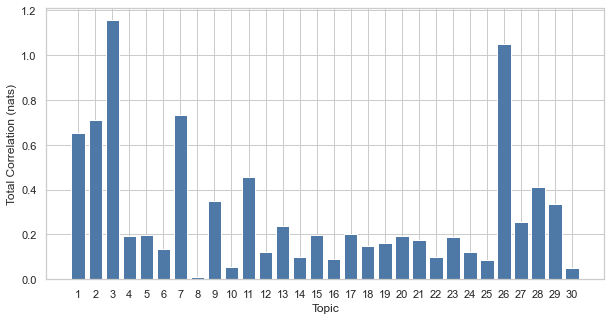

In [120]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10,5))
plt.bar(range(1, topic_model.tcs.shape[0]+1), topic_model.tcs, color='#4e79a7')
plt.xlabel('Topic')
plt.grid('both')
plt.ylabel('Total Correlation (nats)')
plt.xticks(np.arange(1, num_topics+1, step=1))
plt.show()

Some nice visualizations and summaries for the classification data.

In [121]:
# Get the terms for the topics
topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
    # Unpack the info about the topic
    words,mis,signs = zip(*topic)    
    # Print topic
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

# Check to which cluster each tweet belongs
processed_twitter["topic"] = pd.Series(topic_model.labels.tolist())

# Export summary data
vt.vis_rep(topic_model, column_label=word_features, prefix='topic_class_summary')

1: international, business, company, economy, export, leaked, profit, infrastructure, advisory, craft
2: change, green, earth, nature, eternity, prayer, pray, climate, lord, situation
3: city, work, school, job, apply, housing, basketball, freight, training, education
4: ~view, ~beautiful, ~hotel, ~shop, ~bar, ~house, ~located, ~cafe, ~park, ~town
5: cade, anchored, connor, creek, round, petersen, listen, wrestling, pierce, 138
6: national, mgm, memorial, championship, final, golf, estate, oak, meeting, dc
7: wind, gusting, predicted, hpa, knot, pressure, low, tide, mar, high
8: time, ~palm, man, ~fl, ~sale, taking, western, point, run, lost
9: bowline, disappointed, dream, explore, catch, sail, trade, throw, discover, twain
10: tea, tour, evening, beach, hour, boston, drink, weather, enjoy, morning
11: harbour, ~harbor, coffs, portsmouth, flood, darling, cole, dubai, centre, ferry
12: development, service, project, online, week, club, day, staff, custom, member
13: newport, yacht, pri

In [122]:
# Final dataframe
processed_twitter.sort_values(by = ['pos'], ascending=False).head(20)

,id,tweet,clean_tweet,neg,neu,pos,compound,tokens,num_tokens,topic
24036,1501573860105363461,@Valdemort18 Truly worthwhile and honestly a g...,Truly worthwhile and honestly a great scene,0.0,0.139,0.861,0.9081,"[truly, worthwhile, honestly, great, scene]",5,"[False, False, False, True, False, False, Fals..."
9238,1502704474162446341,artist harbour careful congratulations valuabl...,artist harbour careful congratulations valuabl...,0.0,0.156,0.844,0.9451,"[artist, harbour, careful, congratulation, val...",8,"[False, False, False, True, False, False, Fals..."
33623,1500808980498685956,@toastkat GOOD MORNING FRIEND HOPE YOURE ENJOY...,GOOD MORNING FRIEND HOPE YOURE ENJOYING DISNEY,0.0,0.195,0.805,0.9081,"[good, morning, friend, hope, youre, enjoying,...",7,"[False, False, False, True, False, False, Fals..."
22924,1501638292453965828,@dremilyportermd Wow. Just wow. Thanks for s...,Wow. Just wow. Thanks for sharing your story.,0.0,0.231,0.769,0.9231,"[wow, wow, thanks, sharing, story]",5,"[False, False, False, True, False, False, Fals..."
26291,1501348136467369985,PRAISE REPORT God saved Amy’s marriage. All g...,PRAISE REPORT God saved Amy’s marriage. All g...,0.0,0.245,0.755,0.9373,"[praise, report, god, saved, amy, marriage, gl...",8,"[False, False, True, True, False, False, False..."
23772,1501590453010972675,LOVE Earth Harbor. Great stuff https://t.co/...,LOVE Earth Harbor. Great stuff,0.0,0.249,0.751,0.8760,"[love, earth, harbor, great, stuff]",5,"[False, False, False, True, False, False, Fals..."
8373,1502759721090039809,Family fun and making great memories is great!...,Family fun and making great memories is great!...,0.0,0.250,0.750,0.9432,"[family, fun, making, great, memory, great, en...",7,"[False, False, False, True, False, False, Fals..."
5640,1503017979038081035,@Hyperacc21 Pretty sure you harbor some pretty...,Pretty sure you harbor some pretty good charisma,0.0,0.256,0.744,0.8910,"[pretty, sure, harbor, pretty, good, charisma]",6,"[False, False, False, True, False, False, Fals..."
32657,1500874918652616708,@KyivIndependent Love this. Love. Love. Love. ...,Love this. Love. Love. Love. more of this. Lo...,0.0,0.263,0.737,0.9571,"[love, love, love, love, lot]",5,"[False, False, False, True, False, False, Fals..."
7995,1502785324010803204,PRAISE REPORT Found. All glory to God!!!,PRAISE REPORT Found. All glory to God!!!,0.0,0.270,0.730,0.8959,"[praise, report, found, glory, god]",5,"[False, False, False, True, False, False, Fals..."


Quick explanation of the important output files in folder:
- `labels.txt` -> To which group does each tweet belong
  - Similar to `topic_model.labels`
- `topics.txt` -> Top words of each topic

## Visualizations


### Wordmap for all tweets

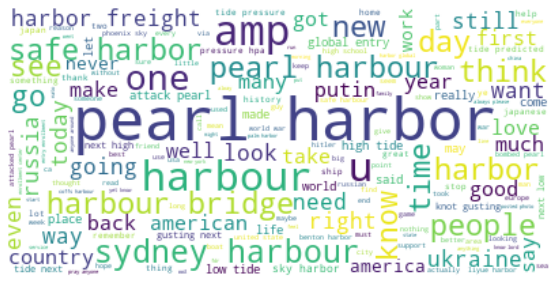

In [123]:
import wordcloud
from wordcloud import WordCloud

mega_string = " ".join(" ".join(tokens) for tokens in processed_twitter["tokens"])

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=1000).generate(mega_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Frequency plot of each topic
Only selected topics

### Total sentiment analysis

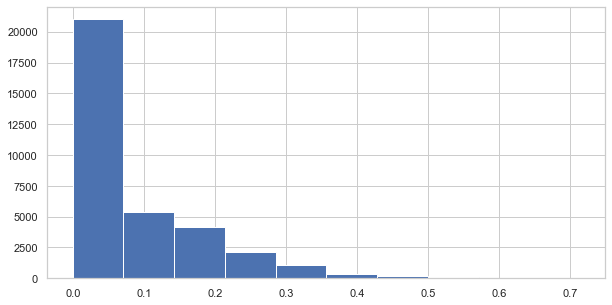

In [129]:
import matplotlib.pyplot as plt
to_plot = np.array(processed_twitter["neg"], processed_twitter["pos"])

plt.hist(to_plot)
plt.show()

### Sentiment analysis per topic

# TODO:
1. Filter out very short tweets DONE
2. Get some nice graphs/plots (e.g. wordclouds from the tokens across all tweets, sentiment analysis summary, etc.)
3. (Maybe) change the "topic" column in the final dataframe for just a single number
   - I.e. instead of `[False True False]` write `2`.
     - Problem -> What about `[False True True`? It belongs to two clusters
4. Finish topic classification with the large dataset (i.e. port_only.csv).
   1. Maybe change the anchors
   2. Get the final topics (i.e. number of topics, keywords, etc.)
   3. Get some nice graphs (e.g. words per topic)
5. (Maybe) fancy cross-correlation plot of sentiment by topic (i.e. are "sustainable" tweets more positive or negative?)
6. Do all of the above for the large dataset (`port_only`), not the small one (`all_hashtags`).


- Wordmap -> All tweets
- Bar graph for each topic (i.e. how many topics per tweet)
- Sentiment according to topic